# Xception_Result

---

#### import

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

## Step 1. 데이터셋 내려받기

#### tf_flowers dataset

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

#### Scale and resize

In [ ]:
IMG_SIZE = 160 # 이미지 크기를 160으로 설정

In [ ]:
def format_example(image, label):   # 이미지와 레이블을 인자로 받는 함수를 정의
    image = tf.cast(image, tf.float32)  # 이미지를 실수형으로 변환
    image = (image/127.5)-1      # 이미지를 -1과 1 사이의 값으로 정규화
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))   # 이미지를 IMG_SIZE에 맞게 크기를 조정
    return image, label # 변환된 이미지와 레이블을 반환

In [ ]:
train = raw_train.map(format_example)   # 훈련 데이터에 함수를 적용하여 변환
validation = raw_validation.map(format_example)   # 검증 데이터에 함수를 적용하여 변환
test = raw_test.map(format_example)     # 테스트 데이터에 함수를 적용하여 변환

#### Check data

In [ ]:
plt.figure(figsize=(10, 5))   # 10x5 크기의 그림을 생성

get_label_name = metadata.features['label'].int2str   # 레이블을 문자열로 변환하는 함수를 정의

<Figure size 1000x500 with 0 Axes>

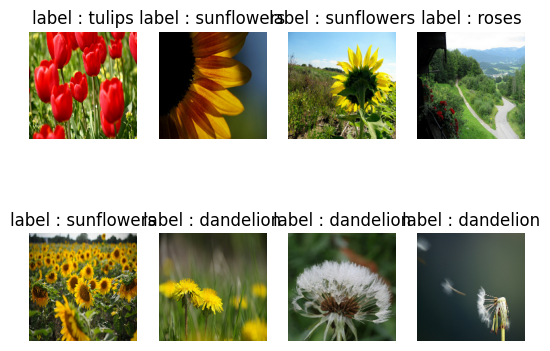

In [ ]:
for idx, (image, label) in enumerate(train.take(8)):  # 훈련 데이터에서 8개의 샘플을 불러옴
    plt.subplot(2,4,idx+1)    # 2x4의 서브플롯을 생성하고 인덱스에 맞게 위치
    image = (image+1)/2   # 이미지를 0과 1 사이의 값으로 복원
    plt.imshow(image)     # 이미지를 그림에 표시
    plt.title('label : {}'.format(get_label_name(label)))   # 레이블을 제목으로 표시
    plt.axis('off')   # 축을 표현하지 않음

## Step 3. 모델 설계하기

#### Base model

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)  # 이미지 (너비, 높이, 채널)

In [ ]:
# # VGG16
# base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
#                                         include_top=False,
#                                         weights='imagenet')

# Xception
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False   # 기본모델 가중치 고정

#### Classifier

In [ ]:
global_average_layer = GlobalAveragePooling2D()   # 전역 평균 풀링 층을 생성
dense_layer = Dense(512, activation='relu')        # 512개의 유닛과 relu 활성화 함수를 가진 밀집 층을 생성
prediction_layer = Dense(5, activation='softmax')  # 5개의 유닛과 softmax 활성화 함수를 가진 밀집 층을 생성

#### Model

In [ ]:
model = Sequential([      # 순차적으로 층을 쌓는 모델을 생성
    base_model,           # 기본 모델을 첫 번째 층으로 추가
    global_average_layer, # 전역 평균 풀링 층을 두 번째 층으로 추가
    dense_layer,          # 밀집 층을 세 번째 층으로 추가
#     Dropout(0.4),
    prediction_layer      # 네번째 층에 예측층 추가
])

In [ ]:
model.summary()  # 모델의 구조와 파라미터 수 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 21,913,133
Trainable params: 1,051,653
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
base_learning_rate = 0.0001  # 기본 학습률
model.compile(optimizer=RMSprop(lr=base_learning_rate),   # 옵티마이저로 RMSprop을 사용하고 학습률을 지정
             loss=sparse_categorical_crossentropy,    # 손실 함수로 희소 범주형 교차 엔트로피를 사용
             metrics=['accuracy'])     # 평가지표: 정확도 사용

## Step 4. 모델 학습시키기

#### Set batch

In [ ]:
BATCH_SIZE = 32   # 32로 배치
SHUFFLE_BUFFER_SIZE = 4000  # 셔플 버퍼 크기를 4000으로 설정

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)   # 훈련 데이터를 셔플하고 배치 크기로 나눔
validation_batches = validation.batch(BATCH_SIZE)  # 검증 데이터를 배치 크기로 나눔
test_batches = test.batch(BATCH_SIZE)  # 테스트 데이터를 배치 크기로 나눔

#### Train model

In [ ]:
EPOCHS = 15
history = model.fit(train_batches, # 모델을 훈련 데이터로 학습
                   epochs = EPOCHS,  # 에포크 수를 지정
                   validation_data = validation_batches)  # 검증 데이터를 사용

Epoch 1/15
92/92 [==============================] - 25s 94ms/step - loss: 0.7432 - accuracy: 0.7442 - val_loss: 0.5611 - val_accuracy: 0.7902
Epoch 2/15
92/92 [==============================] - 9s 76ms/step - loss: 0.3864 - accuracy: 0.8641 - val_loss: 0.7287 - val_accuracy: 0.7711
Epoch 3/15
92/92 [==============================] - 9s 70ms/step - loss: 0.2837 - accuracy: 0.8971 - val_loss: 0.3884 - val_accuracy: 0.8610
Epoch 4/15
92/92 [==============================] - 8s 71ms/step - loss: 0.1928 - accuracy: 0.9343 - val_loss: 0.4003 - val_accuracy: 0.8365
Epoch 5/15
92/92 [==============================] - 9s 73ms/step - loss: 0.1413 - accuracy: 0.9533 - val_loss: 0.4067 - val_accuracy: 0.8856
Epoch 6/15
92/92 [==============================] - 9s 78ms/step - loss: 0.1068 - accuracy: 0.9642 - val_loss: 0.3197 - val_accuracy: 0.8774
Epoch 7/15
92/92 [==============================] - 11s 79ms/step - loss: 0.0663 - accuracy: 0.9792 - val_loss: 0.3451 - val_accuracy: 0.8774
Epoch 8/15


## Step 5. 모델 성능 평가하기

#### Train and validation graph

In [ ]:
acc = history.history['accuracy']   # 훈련 정확도를 acc에 저장
val_acc = history.history['val_accuracy']  # 검증 정확도를 val_acc에 저장

loss = history.history['loss']   # 훈련 손실을 loss에 저장
val_loss = history.history['val_loss']  # 검증 손실을 val_loss에 저장

epochs_range = range(EPOCHS)  # 에포크 범위를 epochs_range에 저장

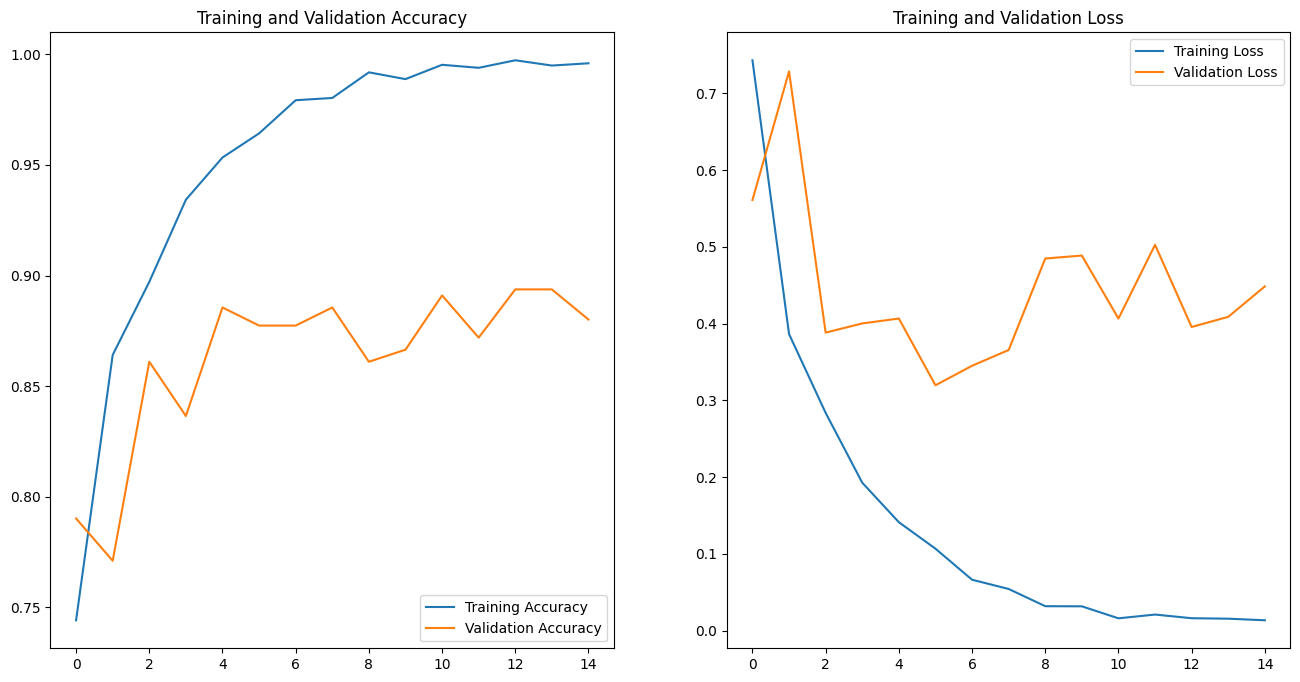

In [ ]:
plt.figure(figsize=(16,8))  # 16x8 크기의 그림
plt.subplot(1,2,1)  # 1x2의 서브플롯을 생성하고 첫 번째 위치에 배치
plt.plot(epochs_range, acc, label='Training Accuracy')   # 에포크 범위와 훈련 정확도를 그래프로 표현(레이블:'Training Accuracy)
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # 에포크 범위와 검증 정확도를 그래프로 표현(레이블:'Validation Accuracy’)
plt.legend(loc='lower right')  # 범례를 오른쪽 아래에 표시
plt.title('Training and Validation Accuracy')  # 제목:'Training and Validation Accuracy’

plt.subplot(1,2,2) # 1x2의 서브플롯을 생성하고 두 번째 위치에 배치
plt.plot(epochs_range, loss, label='Training Loss') # 에포크 범위와 훈련 손실을 그래프로 표현(레이블:'Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss') # 에포크 범위와 검증 손실을 그래프로 표현(레이블:'Validation Loss’)
plt.legend(loc='upper right')  # 범례를 오른쪽 위에 표시
plt.title('Training and Validation Loss') # 제목:'Training and Validation Loss’
plt.show()

#### Predict

In [ ]:
for image_batch, label_batch in test_batches.take(1):  # 테스트 데이터에서 한 배치만 가지고 옴
    images = image_batch   # 이미지는 image_batch에 저장
    labels = label_batch   # 레이블은 label_batch에 저장
    predictions = model.predict(image_batch)  # 모델에 이미지를 입력하여 예측값을 구함

1/1 [==============================] - 1s 1s/step


In [ ]:
predictions = np.argmax(predictions, axis=1)  # 예측값에서 가장 큰 값의 인덱스를 구함

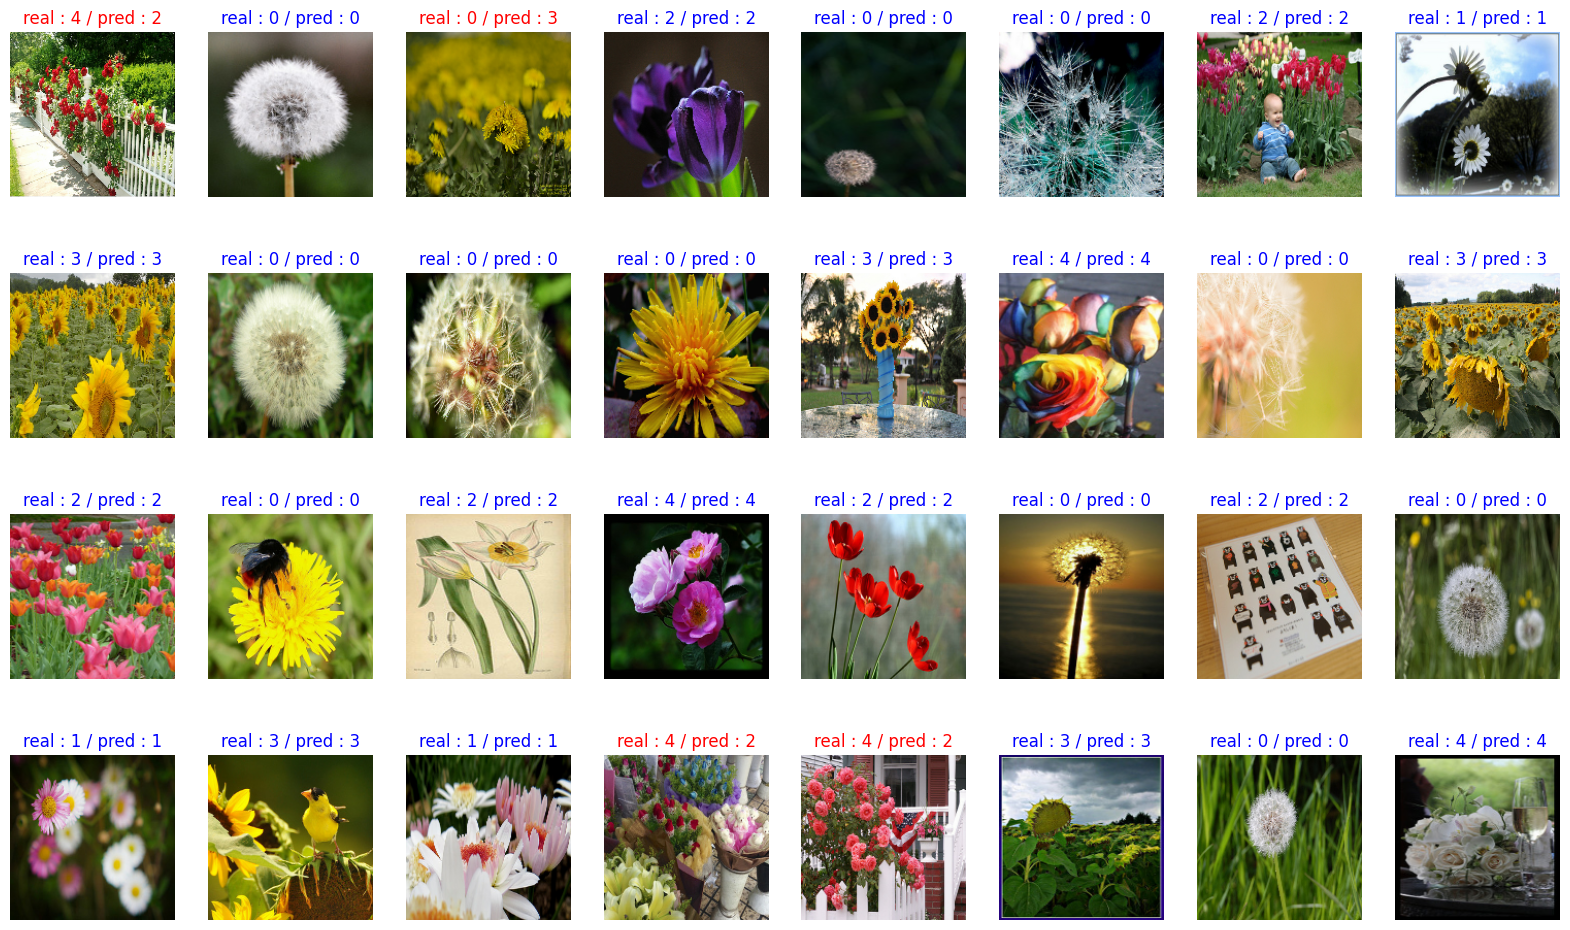

In [ ]:
plt.figure(figsize=(20,12)) # 20x12 크기의 그림을 생성

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):  # 이미지, 레이블, 예측값을 인덱스와 함께 순회
    plt.subplot(4,8,idx+1)  # 4x8의 서브플롯을 생성하고 인덱스에 맞게 위치시킴
    image=(image+1)/2   # 이미지를 0과 1 사이의 값으로 복원
    plt.imshow(image)  # 이미지를 그림에 표시
    correct = label==prediction    # 레이블과 예측값이 일치하는지 확인
    title = 'real : {} / pred : {}'.format(label, prediction)  # 제목: 'real : 레이블 , pred : 예측값’
    if not correct:
        plt.title(title, fontdict={'color':'red'})   # 제목을 빨간색으로 표시
    else:
        plt.title(title, fontdict={'color' : 'blue'})  # 제목을 파란색으로 표시
    plt.axis('off')  # 축을 숨김

In [ ]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):

  if label == prediction:
    count += 1
    print(count / 32 * 100)

3.125
6.25
9.375
12.5
15.625
18.75
21.875
25.0
28.125
31.25
34.375
37.5
40.625
43.75
46.875
50.0
53.125
56.25
59.375
62.5
65.625
68.75
71.875
75.0
78.125
81.25
84.375
87.5


#### Evaluate

In [ ]:
test_loss, test_acc = model.evaluate(test_batches)   # 모델을 테스트 데이터로 평가하고 손실과 정확도를 구합

12/12 [==============================] - 1s 66ms/step - loss: 0.8495 - accuracy: 0.8747


In [ ]:
print(test_acc)     # 테스트 정확도 출력

0.8746594190597534


## Step 6. 모델 활용하기

#### Save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_dir = os.getenv("HOME") + "/content/checkpoint_dir"  # 체크포인트 디렉토리를 환경변수 HOME과 경로를 이어서 설정
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')  # 체크포인트 파일 경로를 디렉토리와 파일명을 이어서 설정

if not os.path.exists('checkpoint_dir'):  # 체크포인트 디렉토리가 존재하지 않으면
    os.mkdir('checkpoint_dir')   # 체크포인트 디렉토리를 생성

In [ ]:
model.save_weights(checkpoint_file_path)    # 모델의 가중치를 체크포인트 파일 경로에 저장

if os.path.exists(checkpoint_file_path):  # 체크포인트 파일 경로가 존재하면 print(‘checkpoint ok’)
    print('checkpoint ok')

checkpoint ok


#### Show and predict

In [ ]:
def show_and_predict(dirpath, filename, img_size=160):    # 이미지 경로, 파일명, 이미지 크기를 인자로 받는 함수를 정의
    filepath = os.path.join(dirpath,filename)     # 이미지 파일 경로를 디렉토리와 파일명을 이어서 설정
    image=load_img(filepath, target_size=(img_size,img_size))    # 이미지 파일을 불러오고 크기를 조정
    plt.imshow(image)  # 이미지를 그림에 표시
    plt.axis('off')  # 축을 숨김
    image = img_to_array(image).reshape(1,img_size,img_size,3)   # 이미지를 배열로 변환하고 모양을 (1, 너비, 높이, 채널)로 변환
    prediction = model.predict(image)[0] # 모델에 이미지를 입력하여 예측값을 구하고 첫 번째 원소를 선택
    idx = np.argmax(prediction)  # 예측값에서 가장 큰 값의 인덱스를 구
    flowers = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'] # 꽃의 종류를 리스트로 저장
    print("This image seems {}% {}.".format(round(prediction[idx]*100),flowers[idx]))  # 이미지가 얼마나 해당 꽃으로 보이는지 백분율과 꽃 이름으로 출력

In [ ]:
image_dir_path = '/content/checkpoint_dir/flower/'  # 이미지 디렉토리 경로를 환경변수 HOME과 경로를 이어서 설정

In [ ]:
filename = 'rose.jpeg'   # 파일명을 'sunflower.jpeg’으로 설정

1/1 [==============================] - 2s 2s/step
This image seems 100% sunflowers.


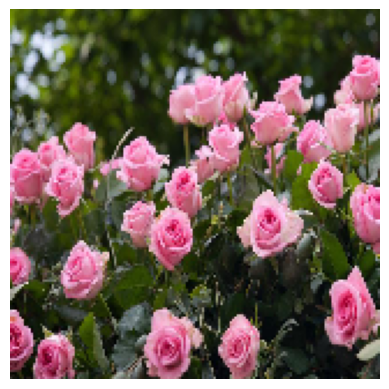

In [ ]:
show_and_predict(image_dir_path, filename)  # 함수에 이미지 디렉토리 경로와 파일명을 입력하여 실행

## Report

1. VGG16 학습결과
pre-trained model
pre-trained model = VGG16  
BATCH_SIZE = 32  
EPOCHS = 15  

<br>

**test accuracy가 85.83% **

<br>
<br>

2.
pre-trained model로 *Xception* 이용
pre-trained model = Xception  
BATCH_SIZE = 32  
EPOCHS = 15  

<br>

**test accuracy가 87.4%**

<br>
<br>

3.
pre-trained model의*Xception*을 이용하고 dropout을 추가하여 학습  
pre-trained model = Xception  
BATCH_SIZE = 32  
EPOCHS = 15  
DROPOUT = 0.5

<br>

**test accuracy: 86.9%**

<br>
<br>

꽃모양이 비슷한 종류는 제대로 구분하지 못함